# Info
This scripts finds those metabolites increased and decreased upon stimulation.
 the rule is abs (log2FC (mean each concentration)) > 1
 also, consider running a statistical test between basal and treatment values for each concentration.

In [1]:
import pandas, numpy, seaborn
import scipy, scipy.stats

import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':20, 'ytick.labelsize':20, 'figure.figsize':(9, 6), 'axes.labelsize':20})

# 0. user-defined variables

In [2]:
storage_file = '/home/adrian/gd15/hi/research/huvec/results/untargeted/cell_number_sample_and_batch_normalized_log10_intensities_untargeted_data.csv'
figures_dir = '/home/adrian/gd15/hi/research/huvec/results/untargeted/figures/flat_responders/'

# 1. read data

In [3]:
# df is log10 intensity
df = pandas.read_csv(storage_file, index_col=0)
print(df.shape)
df.head()

(123, 1233)


,Treatment,Time,Replicate,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,X78.956580000000002,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,EGM,0.0,0.0,2.731190,3.039996,2.498900,3.146793,2.926058,3.101473,4.249783,...,3.021206,2.995128,3.012682,3.068779,3.026200,3.681500,3.728084,3.902864,3.798414,3.779298
1,EGM,0.0,1.0,2.577060,2.966918,2.478636,3.080018,2.975931,3.142122,4.154512,...,3.197100,3.191962,3.090010,3.086108,2.856756,3.666367,3.817882,3.767177,3.784470,3.692333
2,EGM,0.0,2.0,2.567796,3.102377,2.315301,3.174088,3.080577,3.078214,3.950247,...,3.201853,3.251763,3.087607,3.325044,2.495992,3.780564,3.908326,3.861871,3.913619,3.892816
3,EGM,0.0,3.0,2.700993,3.041685,2.328574,3.091159,2.993070,3.046918,4.165901,...,3.056800,3.136908,3.002354,3.164014,2.818191,3.743018,3.851108,3.838991,3.750062,3.818045
4,EGM,0.0,4.0,2.769198,2.967684,2.802023,3.049199,3.131748,3.324679,4.004245,...,3.029694,2.993319,2.978906,3.192828,2.418012,3.710214,3.601818,3.757961,3.739917,3.710246


In [4]:
peak_names = df.columns.to_list()[3:]
print(peak_names[:10])
print(len(peak_names))

['X59.01097', 'X61.017890000000001', 'X67.016220000000004', 'X74.021450000000002', 'X77.052040000000005', 'X77.052049999999994', 'X78.956580000000002', 'X78.956770000000006', 'X79.955420000000004', 'X80.962869999999995']
1230


# 2. obtain data in the appropriate form

In [5]:
change_threshold = 3/2

timepoints = [4, 24]

responders = {}
responders['4up'] = []
responders['4down'] = []
responders['24up'] = []
responders['24down'] = []

for timepoint in timepoints:
    print('working with time {} hour'.format(timepoint))
    sub = df[df['Time'] == timepoint]
    print('\t data size now {}'.format(sub.shape))
    
    for peak_name in peak_names:
        
        reference = sub[sub['Treatment'] == 'EGM'][peak_name].values
        ta = sub[sub['Treatment'] == '1.0'][peak_name].values
        tb = sub[sub['Treatment'] == '10.0'][peak_name].values
        tc = sub[sub['Treatment'] == '100.0'][peak_name].values
        
        # check significance
        statistic, pvaluea = scipy.stats.mannwhitneyu(reference, ta)
        statistic, pvalueb = scipy.stats.mannwhitneyu(reference, tb)
        statistic, pvaluec = scipy.stats.mannwhitneyu(reference, tc)
        
        significance = False
        if pvaluea < 0.05 and pvalueb < 0.05 and pvaluec < 0.05:
            significance = True
            
        # check fold-change
        fca = numpy.mean(ta) - numpy.mean(reference)
        fcb = numpy.mean(tb) - numpy.mean(reference)
        fcc = numpy.mean(tc) - numpy.mean(reference)
        
        change = False
        if numpy.abs(fca) > numpy.log10(change_threshold) and numpy.abs(fcb) > numpy.log10(change_threshold) and numpy.abs(fcc) > numpy.log10(change_threshold):
            
            if fca > 0 and fcb > 0 and fcc > 0:
                change = True
            elif fca < 0 and fcb < 0 and fcc < 0:
                change = True
            else:
                raise ValueError('this is a problem')
                        
#         print(peak_name)
#         print(reference.mean(), ta.mean(), tb.mean(), tc.mean())
#         print(reference.shape, ta.shape, tb.shape, tc.shape)
#         print(pvaluea, pvalueb, pvaluec)
#         print(significance)
#         print(fca, fcb, fcc)
#         print(change)
#         print()
        
        # store findings
        if significance == True and change == True:
            
            print(peak_name)
            print(reference.mean(), ta.mean(), tb.mean(), tc.mean())
            print(reference.shape, ta.shape, tb.shape, tc.shape)
            print(pvaluea, pvalueb, pvaluec)
            print(significance)
            print(fca, fcb, fcc)
            print(change)
            print()
            
            if timepoint == 4:
                if fca > 0 :
                    responders['4up'].append(peak_name)
                if fca < 0:
                    responders['4down'].append(peak_name)
            if timepoint == 24:
                if fca > 0 :
                    responders['24up'].append(peak_name)
                if fca < 0:
                    responders['24down'].append(peak_name)

working with time 4 hour
	 data size now (60, 1233)
X92.925600000000003
4.065751420342374 4.457734027679883 4.455718065528384 4.500816674934927
(15,) (15,) (15,) (15,)
0.00042246757669391977 0.0012151954178690621 0.0012151954178690621
True
0.3919826073375088 0.38996664518600976 0.4350652545925531
True

X97.009529999999998
3.863376397504625 3.3741251735800377 3.5106691460369643 3.4898801214779764
(15,) (15,) (15,) (15,)
0.00013564226281566485 0.0006709034051003711 0.0036905851986807135
True
-0.4892512239245872 -0.3527072514676606 -0.3734962760266485
True

X129.03619
3.955803887369545 3.720999695468026 3.7487633293299862 3.775707316131263
(15,) (15,) (15,) (15,)
0.0003069120099060342 0.0006699752744407298 0.008964395568369175
True
-0.23480419190151913 -0.20704055803955868 -0.18009657123828182
True

X146.07991000000001
3.575418567293576 3.332016486851072 3.3382923903532586 3.220835168087748
(15,) (15,) (15,) (15,)
0.011391839029577161 0.0036867798789082876 0.0009046519651376868
True
-0.24

In [6]:
print(len(responders['4up']))
print(len(responders['4down']))
print(len(responders['24up']))
print(len(responders['24down']))

8
5
3
3


In [7]:
print(responders['4up'])
print(responders['4down'])
print(responders['24up'])
print(responders['24down'])

['X92.925600000000003', 'X240.04951', 'X272.79386', 'X299.25677000000002', 'X502.63119', 'X502.64560999999998', 'X560.60392999999999', 'X562.59050999999999']
['X97.009529999999998', 'X129.03619', 'X146.07991000000001', 'X218.10158000000001', 'X883.57375000000002']
['X175.02331000000001', 'X276.05410000000001', 'X353.04653999999999']
['X277.18092999999999', 'X306.07517999999999', 'X564.56741999999997']


# 3. make figures

In [8]:
plotting_peaks = []

for element in responders['4up']:
    plotting_peaks.append(element)
    
for element in responders['4down']:
    plotting_peaks.append(element)
    
for element in responders['24up']:
    plotting_peaks.append(element)

for element in responders['24down']:
    plotting_peaks.append(element)
    
print(len(plotting_peaks))
print(len(list(set(plotting_peaks))))

19
19


X92.925600000000003


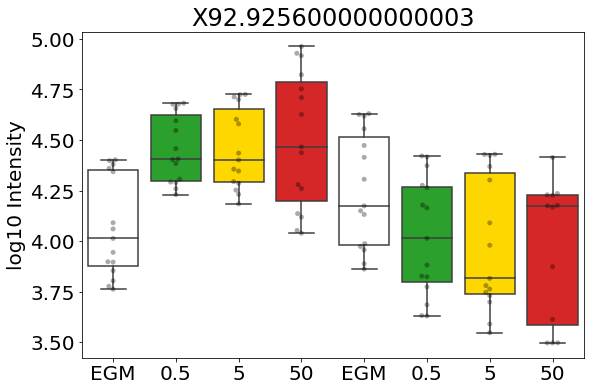

X240.04951


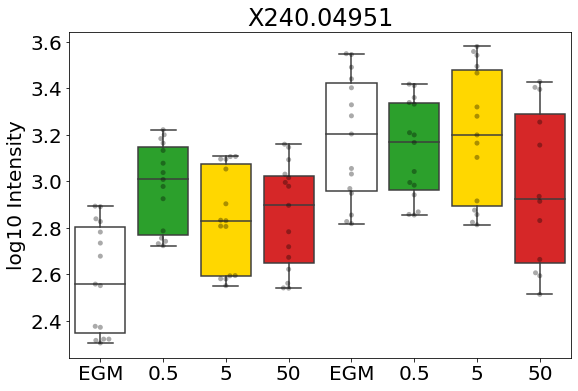

X272.79386


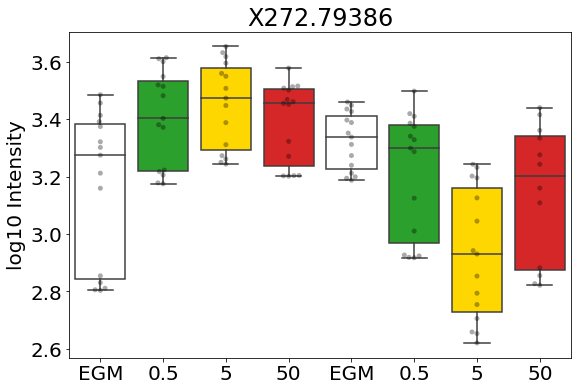

X299.25677000000002


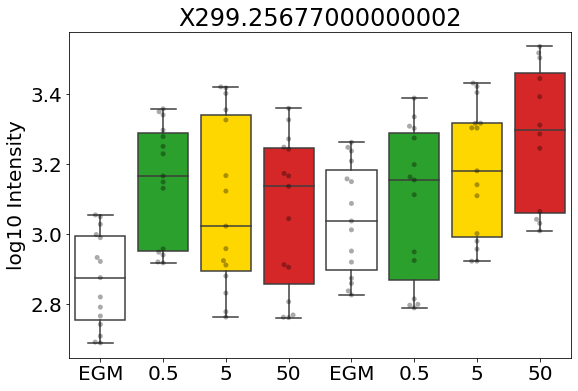

X502.63119


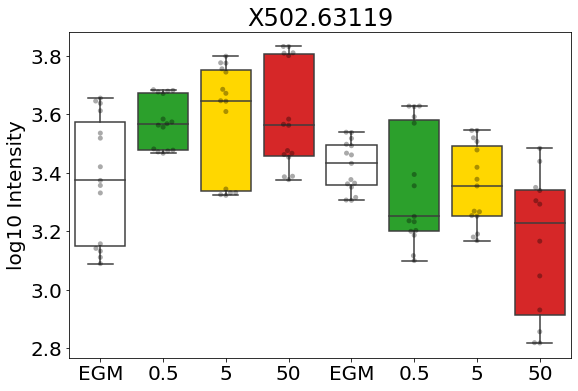

X502.64560999999998


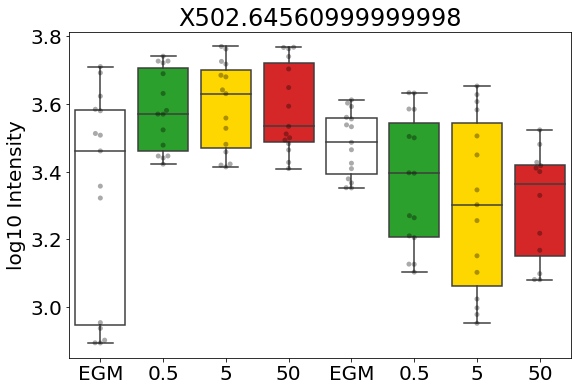

X560.60392999999999


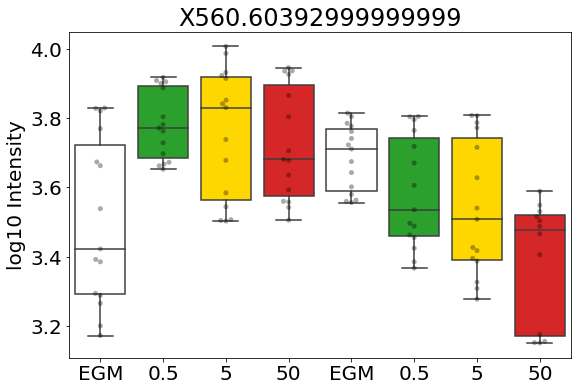

X562.59050999999999


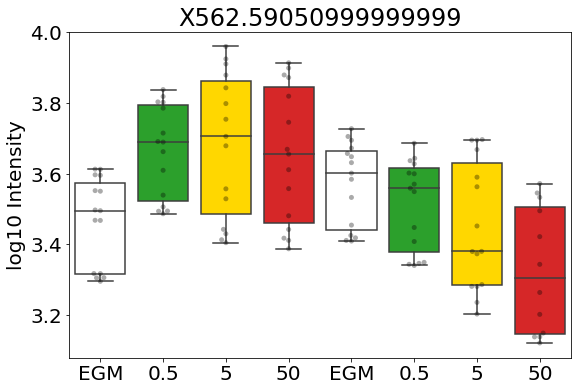

X97.009529999999998


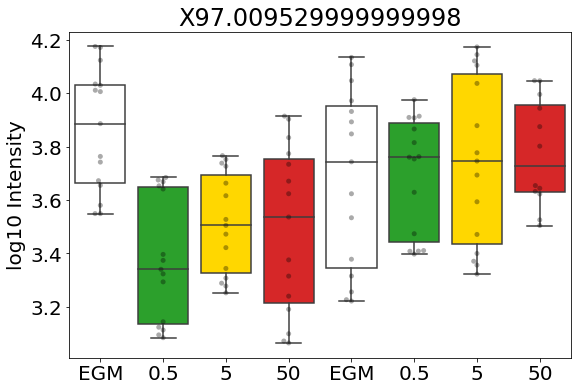

X129.03619


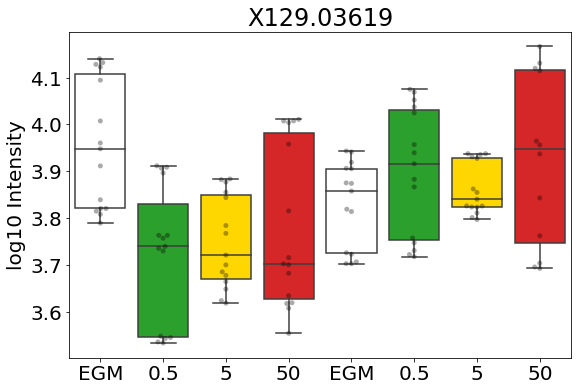

X146.07991000000001


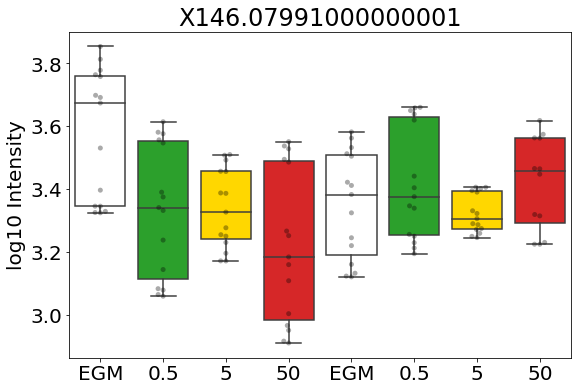

X218.10158000000001


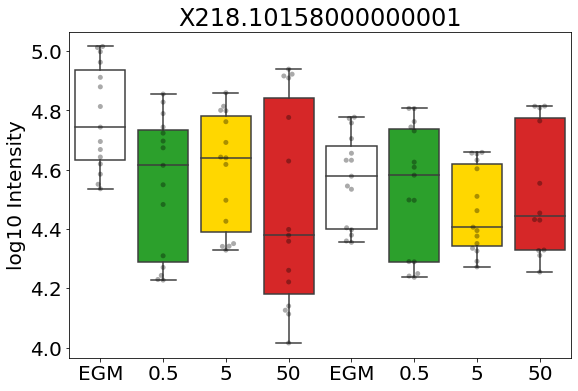

X883.57375000000002


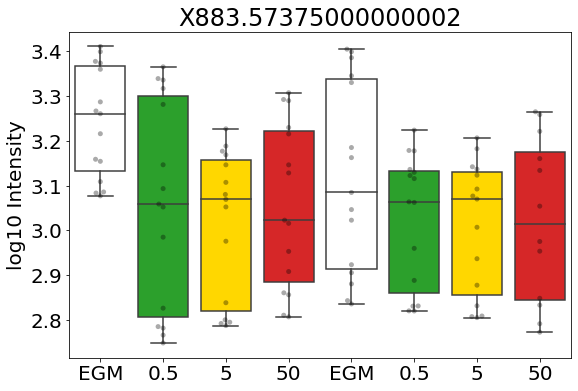

X175.02331000000001


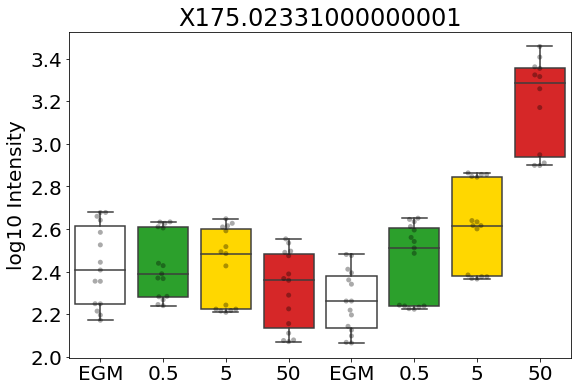

X276.05410000000001


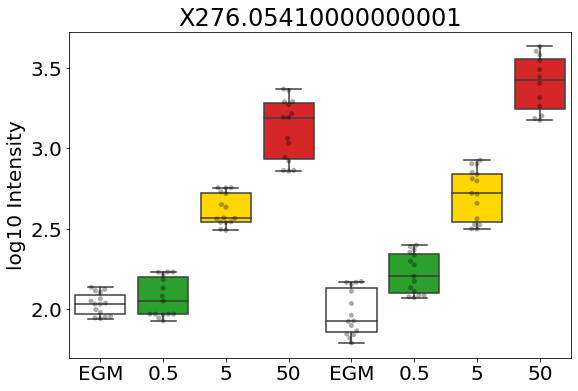

X353.04653999999999


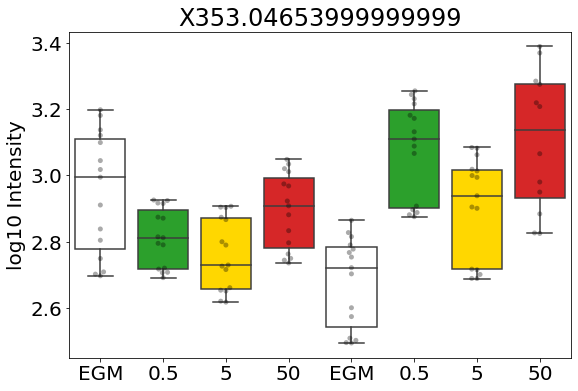

X277.18092999999999


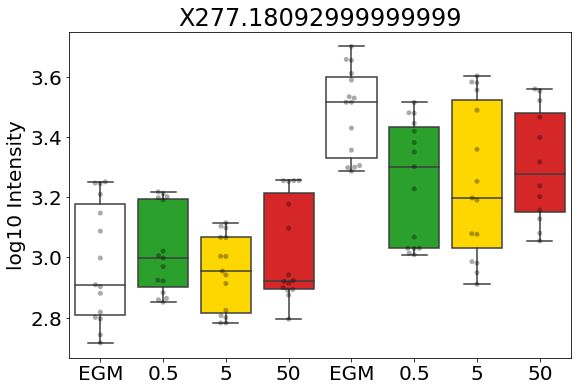

X306.07517999999999


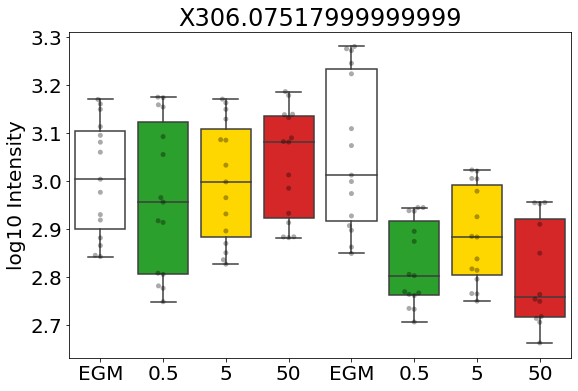

X564.56741999999997


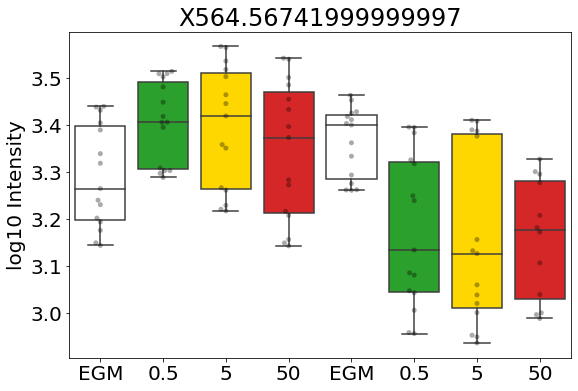

In [9]:
references = [(4, 'EGM'), (24, 'EGM')]
conditions = ['1.0', '10.0', '100.0']

for plotting_peak in plotting_peaks:
    print(plotting_peak)
    all_boxplot_values = []
    
    for reference in references:
        denominator_values = df[(df['Time'] == reference[0]) & (df['Treatment'] == reference[1])][plotting_peak].values
        all_boxplot_values.append(denominator_values)
        for condition in conditions:
            numerator_values = df[(df['Time'] == reference[0]) & (df['Treatment'] == condition)][plotting_peak].values
            all_boxplot_values.append(numerator_values)
            
    # generate figure of boxplots
    g = seaborn.boxplot(data=all_boxplot_values)
    h = seaborn.swarmplot(data=all_boxplot_values, color='black', alpha=1/3)
    
    wcolors = ['white', 'tab:green', 'gold', 'tab:red', 'white', 'tab:green', 'gold', 'tab:red']
    for i in range(len(g.artists)):
        g.artists[i].set_facecolor(wcolors[i])
        
    
    matplotlib.pyplot.xticks([0, 1, 2, 3, 4, 5, 6, 7], ['EGM', '0.5', '5', '50', 'EGM', '0.5', '5', '50'])
    matplotlib.pyplot.ylabel('log10 Intensity')
    matplotlib.pyplot.title(plotting_peak)
    
    matplotlib.pyplot.show()
 
            
            

# making plots of specific metaoblites.

UDP Glucose	565.047	5.9
UDP  nAcetylglucosamine	606.064	5.56
phosphocholine	242.077	4.75
Inosine	267.066	3.565
Possible cAMP	328.0435	4.5
Possible cAMP	350.042	4.5

ADP Nactelyglucosamine is not strictly found:
mz RT
606.075244	6.209333
606.0859127	6.280417

In [10]:
particular_targets = [565.047, 606.064, 242.077, 267.066, 328.0435, 350.042]
        
for particular_target in particular_targets:
    for peak_name in peak_names:
        mz = float(peak_name[1:])
        diff = numpy.abs(mz - particular_target)
        if diff < 0.02:
            print('working with', particular_target, peak_name, diff)
            
            reference = sub[sub['Treatment'] == 'EGM'][peak_name].values
            ta = sub[sub['Treatment'] == '1.0'][peak_name].values
            tb = sub[sub['Treatment'] == '10.0'][peak_name].values
            tc = sub[sub['Treatment'] == '100.0'][peak_name].values

            # check significance
            statistic, pvaluea = scipy.stats.mannwhitneyu(reference, ta)
            statistic, pvalueb = scipy.stats.mannwhitneyu(reference, tb)
            statistic, pvaluec = scipy.stats.mannwhitneyu(reference, tc)
            
            # check fold-change
            fca = numpy.mean(ta) - numpy.mean(reference)
            fcb = numpy.mean(tb) - numpy.mean(reference)
            fcc = numpy.mean(tc) - numpy.mean(reference)
            
            
            print(reference.mean(), ta.mean(), tb.mean(), tc.mean())
            print(reference.shape, ta.shape, tb.shape, tc.shape)
            print('P', pvaluea, pvalueb, pvaluec)
            print('log2FC', fca, fcb, fcc)
            print()

working with 565.047 X565.05041000000006 0.0034100000000307773
3.560989601980632 3.6502021760888326 3.561936051810093 3.632724453241987
(15,) (15,) (15,) (12,)
P 0.21337370709311831 0.9338864180775845 0.4207518433669324
log2FC 0.08921257410820038 0.0009464498294606827 0.07173485126135493

working with 606.064 X606.07524000000001 0.011240000000043437
4.1091082835290775 4.20851527956058 4.0804702072038905 4.2089592276101895
(15,) (15,) (15,) (12,)
P 0.26275304114766074 0.7089232340537643 0.25151283025221316
log2FC 0.09940699603150271 -0.028638076325187 0.09985094408111195

working with 242.077 X242.07813999999999 0.0011399999999923693
3.9281555457659625 3.9236739400911937 3.823108230244288 3.994098672845212
(15,) (15,) (15,) (12,)
P 0.8357050269952793 0.08901797772326324 0.08318687714512733
log2FC -0.0044816056747687405 -0.10504731552167446 0.06594312707924965

working with 267.066 X267.07112000000001 0.005120000000033542
2.684916146654275 2.69307103357508 2.6185419281662576 2.7598498172